In [294]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import ast
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


df = pd.read_csv("pull_request_metrics.csv")
#df.dropna(inplace=True)
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 26 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   pr_number                    3870 non-null   int64  
 1   created_at                   3870 non-null   object 
 2   merged_at                    3870 non-null   object 
 3   author                       3870 non-null   object 
 4   number_of_comments           3870 non-null   int64  
 5   number_of_review_comments    3870 non-null   int64  
 6   number_of_commits            3870 non-null   int64  
 7   lines_of_code_changed        3870 non-null   int64  
 8   number_of_files_changed      3870 non-null   int64  
 9   number_of_reviewers          3870 non-null   int64  
 10  number_of_approvals          3870 non-null   int64  
 11  labels                       3870 non-null   object 
 12  time_to_first_response       2818 non-null   float64
 13  number_of_assignee

In [295]:
# drop time_since_last_commit and test_coverage columns
df.drop(['time_since_last_commit', 'test_coverage','dependency_changes', 'number_of_linked_issues', 'number_of_milestones'], axis=1, inplace=True)

#divide review_duration and time to first reponse  by 3600 to get hours
df['review_duration'] = df['review_duration']/3600
df['time_to_first_response'] = df['time_to_first_response']/3600


In [296]:

# Ensure 'comment_authors' is a list
df['comment_authors'] = df['comment_authors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Add a new column to count the number of comment authors
df['num_comment_authors'] = df['comment_authors'].apply(lambda x: len(x) if x else 0)

#if issue has comments fll 'reviewed' with 1 else 0
df['reviewed'] = df['num_comment_authors'].apply(lambda x: 1 if x > 0 else 0)
df['time_to_first_response'] = df['time_to_first_response'].fillna(0)

#drop comment_authors column
df.drop(['comment_authors'], axis=1, inplace=True)


In [297]:
df['code_changes_ratio'] = df['lines_of_code_changed'] / df['number_of_files_changed']

#if code_changes_ratio is nan fill with 0
df['code_changes_ratio'] = df['code_changes_ratio'].fillna(0)


In [298]:
# Function to remove specific prefixes from labels
def remove_prefixes(labels):
    if pd.isna(labels):
        return labels
    prefixes = ['type:', 'scope:', 'platform:', 'status:', 'other:','[',']']
    for prefix in prefixes:
        labels = labels.replace(prefix, '')
    return labels

# Apply the function to the 'Labels' column
df['labels'] = df['labels'].apply(remove_prefixes)

# make a list of all the unique labels
unique_labels = df['labels'].str.split(',').explode().str.strip().unique()

#delete nan
unique_labels = [x for x in unique_labels if str(x) != 'nan']

# add a column for each unique label
for item in unique_labels:
    if isinstance(item, str) and item:
        df[item] = df['labels'].apply(lambda x: 1 if isinstance(x, str) and item in x else 0)

# add a column that counts the number of labels
df['label_count'] = df['labels'].str.split(',').apply(lambda x: len(x) if isinstance(x, list) else 0)

df.drop(['labels'], axis=1, inplace=True)

In [299]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['merged_at'] = pd.to_datetime(df['merged_at'], format='%Y-%m-%dT%H:%M:%SZ', errors='coerce')
df['Issue_Lifetime(hours)'] = (df['merged_at'] - df['created_at']).dt.total_seconds() / 3600


# Define the conditions for the 'Issue Lifetime' groups
conditions = [
    (df['Issue_Lifetime(hours)'] < 6),  # less than 6 hours - group 1
    (df['Issue_Lifetime(hours)'] >= 6) & (df['Issue_Lifetime(hours)'] < 48), # between 6 hours and 2 days - group 2
    (df['Issue_Lifetime(hours)'] >= 48) & (df['Issue_Lifetime(hours)'] < 720),  # between 2 days and a month - group 3
    (df['Issue_Lifetime(hours)'] >= 720)  # more than a month - group 4
]

# Define the corresponding group numbers
groups = [1, 2, 3, 4]
group_dict={
    1: 'Less than 6 hours',
    2: 'Between 6 hours and 2 days',
    3: 'Between 2 days and a month',
    4: 'More than a month'
}

# Create the 'Issue Lifetime' column using np.select
df['Issue Lifetime'] = np.select(conditions, groups)

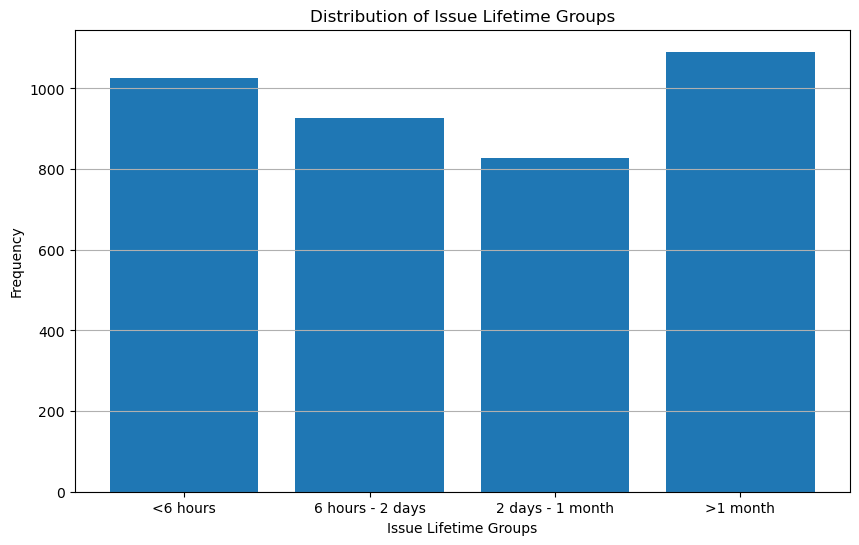

In [300]:
# Graphing the distribution of the groups
group_counts = df['Issue Lifetime'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
plt.bar(group_counts.index, group_counts.values, tick_label=['<6 hours','6 hours - 2 days', '2 days - 1 month', '>1 month'])
plt.title('Distribution of Issue Lifetime Groups')
plt.xlabel('Issue Lifetime Groups')
plt.ylabel('Frequency')
plt.grid(True, axis='y')
plt.show()

In [301]:
# fro each row calcualte how many Issue have been opened since 2 weeks before teh current issue was opened
df['Issues Opened in Last 2 Weeks'] = 0
for i in range(0, len(df)):
    open_date = df['created_at'][i]
    two_weeks_before = open_date - pd.Timedelta(days=14)
    issues_opened = df[(df['created_at'] >= two_weeks_before) & (df['created_at'] < open_date)].shape[0]
    df.loc[i, 'Issues Opened in Last 2 Weeks'] = issues_opened
    
# fro each row calcualte how many Issue have been closed since 2 weeks before teh current issue was opened
df['Issues Closed in Last 2 Weeks'] = 0
for i in range(0, len(df)):
    closed_date = df['merged_at'][i]
    two_weeks_before = closed_date - pd.Timedelta(days=14)
    issues_closed = df[(df['merged_at'] >= two_weeks_before) & (df['merged_at'] < closed_date)].shape[0]
    df.loc[i, 'Issues Closed in Last 2 Weeks'] = issues_closed


# for each row calcualte the nubmer of open pull requests at the time the issue was opened i.e pr merge date is after the open date
df['Open PRs at Open Date'] = 0
for i in range(len(df)):
    open_date = df.loc[i, 'created_at']
    open_prs = df[(df['created_at'] < open_date) & (df['merged_at'] > open_date)].shape[0]
    df.loc[i, 'Open PRs at Open Date'] = open_prs
    


In [302]:
#for each row calcualte how many pull requests were opened before by the author
df['Author PRs Opened'] = 0
for i in range(len(df)):
    author = df.loc[i, 'author']
    author_prs = df[(df['author'] == author) & (df['created_at'] < df['created_at'][i])].shape[0]
    df.loc[i, 'Author PRs Opened'] = author_prs
    
#drop created_at and merged_at columns
df.drop(['created_at', 'merged_at','author'], axis=1, inplace=True)

In [303]:
#calcualte the correlation matrix
correlation_matrix = df.corr()
correlation_matrix


,pr_number,number_of_comments,number_of_review_comments,number_of_commits,lines_of_code_changed,number_of_files_changed,number_of_reviewers,number_of_approvals,time_to_first_response,number_of_assignees,...,' search',' device specific',' decayed',label_count,Issue_Lifetime(hours),Issue Lifetime,Issues Opened in Last 2 Weeks,Issues Closed in Last 2 Weeks,Open PRs at Open Date,Author PRs Opened
pr_number,1.000000,0.070914,0.093403,0.079155,0.043654,0.081636,0.464116,0.511811,-0.484858,-0.085992,...,-0.008227,-0.009453,0.001570,0.529667,-0.684014,-0.572845,-0.458803,-0.333747,-0.510325,0.504584
number_of_comments,0.070914,1.000000,0.327182,0.304325,-0.005384,0.006948,0.384387,0.216283,-0.077121,0.102572,...,0.011656,0.032273,0.010911,0.110708,-0.087030,0.132801,-0.129840,-0.069526,-0.066270,-0.139724
number_of_review_comments,0.093403,0.327182,1.000000,0.502415,0.002543,0.002658,0.475255,0.156804,-0.072730,0.130677,...,-0.006112,-0.004321,0.009795,0.133035,-0.077551,0.110574,-0.112120,-0.059221,-0.026424,-0.076347
number_of_commits,0.079155,0.304325,0.502415,1.000000,0.013236,0.012907,0.228181,0.043775,-0.058842,0.150983,...,0.015668,0.002266,-0.001259,0.134670,-0.043567,0.142003,-0.079294,-0.071843,-0.015519,-0.072213
lines_of_code_changed,0.043654,-0.005384,0.002543,0.013236,1.000000,0.682906,-0.011477,-0.027785,-0.017959,-0.005767,...,-0.000759,-0.000836,-0.000875,0.063537,-0.026369,-0.019282,-0.018833,-0.006501,-0.027686,0.050150
number_of_files_changed,0.081636,0.006948,0.002658,0.012907,0.682906,1.000000,-0.014223,-0.017539,-0.030908,-0.011149,...,-0.000544,-0.001308,-0.001521,0.115124,-0.039813,-0.035429,-0.035833,-0.027447,-0.040334,0.098020
number_of_reviewers,0.464116,0.384387,0.475255,0.228181,-0.011477,-0.014223,1.000000,0.831395,-0.210748,0.030447,...,-0.017782,0.036616,0.022562,0.334838,-0.322230,-0.176422,-0.296355,-0.119759,-0.297453,0.193370
number_of_approvals,0.511811,0.216283,0.156804,0.043775,-0.027785,-0.017539,0.831395,1.000000,-0.200359,-0.023056,...,-0.029948,0.032360,0.014515,0.332396,-0.344868,-0.301326,-0.297570,-0.109764,-0.340725,0.297148
time_to_first_response,-0.484858,-0.077121,-0.072730,-0.058842,-0.017959,-0.030908,-0.210748,-0.200359,1.000000,-0.010508,...,-0.007710,-0.005414,-0.005451,-0.227498,0.669605,0.431648,0.354830,0.403284,0.229905,-0.201639
number_of_assignees,-0.085992,0.102572,0.130677,0.150983,-0.005767,-0.011149,0.030447,-0.023056,-0.010508,1.000000,...,-0.005235,-0.003701,-0.003701,0.003724,-0.000723,0.133264,0.032333,-0.021453,0.107433,-0.080944


In [304]:
# Prepare features and target variable
target = df['Issue Lifetime']
features= df.drop(['Issue Lifetime','Issue_Lifetime(hours)', 'review_duration'], axis=1)

# Convert categorical features to dummy variables
features = pd.get_dummies(features, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

In [305]:
# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Feature importance
feature_importances = pd.Series(rf_classifier.feature_importances_, index=features.columns).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)


Accuracy Score: 0.6804478897502153
Confusion Matrix:
 [[201  65  16   5]
 [ 85 144  71   5]
 [ 22  33 167  12]
 [  3   3  51 278]]
Classification Report:
               precision    recall  f1-score   support

           1       0.65      0.70      0.67       287
           2       0.59      0.47      0.52       305
           3       0.55      0.71      0.62       234
           4       0.93      0.83      0.88       335

    accuracy                           0.68      1161
   macro avg       0.68      0.68      0.67      1161
weighted avg       0.69      0.68      0.68      1161

Feature Importances:
 pr_number                        0.133474
Issues Opened in Last 2 Weeks    0.117241
Open PRs at Open Date            0.092411
Author PRs Opened                0.088296
time_to_first_response           0.068048
Issues Closed in Last 2 Weeks    0.066362
lines_of_code_changed            0.045349
code_changes_ratio               0.043354
number_of_files_changed          0.037331
number_of_

In [346]:
# Get the correlations with 'review_duration'
review_duration_corr = correlation_matrix['Issue_Lifetime(hours)']

# Define a threshold for strong correlation (e.g., |correlation| > 0.5)
threshold = 0.09

# Filter the correlations that are above the threshold
strong_correlations = review_duration_corr[review_duration_corr.abs() > threshold].sort_values(ascending=False)

# Remove self-correlation
strong_correlations = strong_correlations.drop(labels=['Issue_Lifetime(hours)'])

# Display the strong correlations
print("Strong Correlations with 'Issue_Lifetime(hours)':\n", strong_correlations)

# Extract the columns that have strong correlations
strong_corr_columns = strong_correlations.index.tolist()

# Create a DataFrame with these columns
df_strong_corr = df[strong_corr_columns]

#df_strong_corr

Strong Correlations with 'Issue_Lifetime(hours)':
 Issue Lifetime                   0.702272
time_to_first_response           0.669605
Issues Opened in Last 2 Weeks    0.657056
Issues Closed in Last 2 Weeks    0.497648
Open PRs at Open Date            0.426441
review_duration                  0.281758
' merge conflict'                0.093029
' i18n'                         -0.105792
' docs'                         -0.113099
' curriculum'                   -0.119576
number_of_build_runs            -0.127055
number_of_reviews_requested     -0.134239
' tools/scripts'                -0.165484
'crowdin-sync'                  -0.165821
num_comment_authors             -0.189730
' waiting review'               -0.190636
'renovate'                      -0.198824
' learn'                        -0.266773
Author PRs Opened               -0.321868
number_of_reviewers             -0.322230
label_count                     -0.330611
number_of_approvals             -0.344868
pr_number                

In [347]:
target2 = df_strong_corr['Issue Lifetime']

# features should exclude the target variable
features=df_strong_corr.drop(['Issue Lifetime', 'review_duration'], axis=1)

#features=df_strong_corr.drop('Issue Lifetime')
#df_strong_corr

# Convert categorical features to dummy variables
features = pd.get_dummies(features, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target2, test_size=0.3, random_state=42)

# Train the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

In [348]:
# Evaluate the model
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy Score: 0.7028423772609819
Confusion Matrix:
 [[205  61  17   4]
 [ 81 154  63   7]
 [ 19  30 174  11]
 [  5   2  45 283]]
Classification Report:
               precision    recall  f1-score   support

           1       0.66      0.71      0.69       287
           2       0.62      0.50      0.56       305
           3       0.58      0.74      0.65       234
           4       0.93      0.84      0.88       335

    accuracy                           0.70      1161
   macro avg       0.70      0.70      0.70      1161
weighted avg       0.71      0.70      0.70      1161



In [349]:
# Feature importance
feature_importances = pd.Series(rf_classifier.feature_importances_, index=features.columns).sort_values(ascending=False)
print("Feature Importances:\n", feature_importances)

Feature Importances:
 pr_number                        0.186105
Issues Opened in Last 2 Weeks    0.156361
Open PRs at Open Date            0.119382
Author PRs Opened                0.108685
Issues Closed in Last 2 Weeks    0.095408
time_to_first_response           0.089445
num_comment_authors              0.050751
number_of_reviewers              0.037263
number_of_approvals              0.023729
label_count                      0.021961
' curriculum'                    0.020495
' waiting review'                0.016808
' learn'                         0.013349
number_of_reviews_requested      0.011772
'crowdin-sync'                   0.010334
number_of_build_runs             0.008454
'renovate'                       0.008391
' tools/scripts'                 0.007899
' docs'                          0.006758
' i18n'                          0.006295
' merge conflict'                0.000355
dtype: float64


# LLM

In [356]:
import json

# Combine X_train and y_train into a single DataFrame
df_LLM_train = pd.concat([X_train, y_train], axis=1)

# Combine X_test and y_test into a single DataFrame
df_LLM_test = pd.concat([X_test, y_test], axis=1)

In [354]:
# Invoking the API
from openai import OpenAI
client = OpenAI(api_key = 'open-ai-key')

In [361]:
# Open the file in write mode
with open('/Users/atu/Documents/TTS/Final_Attempt/issue_lifetime_data.jsonl', 'w', encoding='utf-8') as f:
    # Iterate over the rows in the DataFrame
    for index, row in df_LLM_train.iterrows():
        # Create the user message by formatting the prompt with the valuea frome each column for each row
        user_message = f"Classify, using ONLY 1 NUMBER between 1 and 4, the following GitHub issue, where 1 is 'Less than 6 hours', 2 is 'Between 6 hours and 2 days', 3 is 'Between 2 days and a month', and 4 is 'More than a month', based on its features: row {index}:\n{row.to_string()}\n"
        
        # Create the assistant message by taking the label
        assistant_message = row['Issue Lifetime']
        
        # Construct the conversation object
        conversation_object = {
            "messages": [
                {"role": "system", "content": "GitHub Issue Report Classifier"},
                {"role": "user", "content": user_message},
                {"role": "assistant", "content": assistant_message}
            ]
        }
        
        # Write the conversation object to one line in the file
        f.write(json.dumps(conversation_object, ensure_ascii=False) + '\n')

## Training the file

In [365]:
import json

## Uplopading a training file
ft_file = client.files.create(
  file=open("/Users/atu/Documents/TTS/Final_Attempt/issue_lifetime_data.jsonl", "rb"),
  purpose="fine-tune"
)
ft_file

FileObject(id='file-9yk1Jnox1kVwIvIT9bd5pMBc', bytes=3777838, created_at=1718701882, filename='issue_lifetime_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

## Model creation

In [367]:
## Creating a fine-tuned model
ft_job = client.fine_tuning.jobs.create(
  training_file=ft_file.id, 
  model="gpt-3.5-turbo",
  suffix= "git-issueclass"
)

ft_job

BadRequestError: Error code: 400 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details.', 'type': 'invalid_request_error', 'param': None, 'code': 'exceeded_quota'}}